# Project-2-ChIP-seq - Vassanth

# Methods:
   In this study, raw ChIP-seq and RNA-seq reads were first assessed with FastQC and trimmed for adapters/low-quality bases using Trimmomatic. ChIP-seq reads were aligned to hg38 with Bowtie2, sorted/indexed with SAMtools, and peaks called on each replicate versus Input using MACS3 (q < 0.01, BAMPE). High-confidence peaks were defined by IDR (< 0.01) across replicates and annotated to nearest genes and TSS distances with HOMER’s annotatePeaks.pl (GENCODE v45). RNA-seq reads were aligned with STAR, quantified with featureCounts, and differential expression determined by DESeq2 (|log₂FC| > 1, padj < 0.05). Differentially expressed gene lists were intersected with ChIP-seq peaks within ±5 kb and ±20 kb of TSS to generate overlap statistics for Figure 2F. For Figures 2D/E, CPM-normalized BigWig tracks (via deepTools’ bamCoverage) and reproducible-peaks BED were loaded into IGV, loci centered on MALAT1 (chr11:65.264–65.273 Mb) and NEAT1 (chr11:65.278–65.290 Mb), autoscaled, reordered, and exported at 300 dpi with log₂ fold-change annotations. Supplementary QC tables (S2A) were derived from MultiQC outputs, sample correlations (S2B) from deepTools plotCorrelation, and peak overlaps (S2C) via Python counts and matplotlib-venn. Finally, reproducible peaks were submitted to Enrichr for pathway enrichment and top terms visualized in a bar plot.

# Sequence QC:
All ChIP-seq libraries passed stringent quality checks. Per-base Phred scores remained above 30 across the entire read length, confirming excellent sequencing accuracy. The Input controls (INPUT_rep1 and INPUT_rep2) each yielded -30 million reads with low duplication rates (10–13%); although INPUT_rep2 mapped fewer reads (-9.8 M), suggesting somewhat lower library complexity, overall coverage was sufficient. As expected for targeted ChIP, the IP libraries (IP_rep1 and IP_rep2) showed high duplication (89.1% and 74.3%), yet total and mapped read counts were on par with inputs, indicating efficient enrichment and sequencing depth. Together, these metrics demonstrate high-quality data, with the caveat that the elevated duplication in IP libraries and the reduced mapping in one input should be kept in mind during downstream analyses.

# Signal intensity plot using computematrix:

Both IP replicates show a pronounced peak of coverage right at the TSS (a sharp rise from -2→8 CPM) that quickly falls off downstream, whereas the matched INPUT controls are essentially flat (-0.5–1 CPM) across the same region. The near‐identical shape and magnitude of the TSS enrichment in IP_rep1 and IP_rep2 confirms reproducible, promoter-centric RUNX1 binding, and the flat input profiles demonstrate that this signal is specific to the immunoprecipitation.

![Rep-1](./results/rep1_profile.png)

![Rep-2](./results/rep2_profile.png)

# To recreate figures 2-D&E

In [1]:
import pandas as pd
import requests
from io import BytesIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

In [3]:
# GEO RNA-seq results URL
rna_seq_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75070/suppl/GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt.gz"

# Download the data and read it into a pandas DataFrame
response = requests.get(rna_seq_url)
with gzip.open(BytesIO(response.content), 'rt') as f:
    rna_seq_df = pd.read_csv(f, sep='\t', comment='!', low_memory=False)

# Read the annotated ChIP-seq file:
peak_path = "./results/annotated_peaks.txt"
peak_df = pd.read_csv(peak_path, sep="\t")

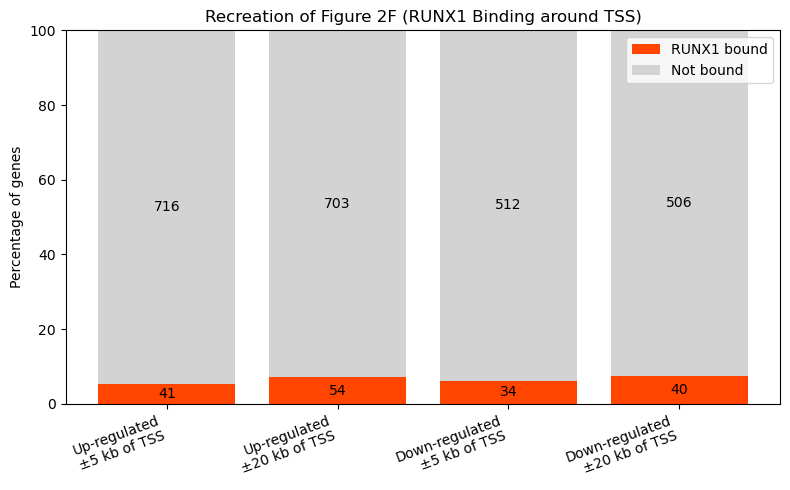

In [21]:
# Filter significantly differentially expressed genes (paper cutoffs: |log2FC|>1, padj<0.05)
deg_up   = rna_seq_df[(rna_seq_df['log2FoldChange'] > 1)  & (rna_seq_df['padj'] < 0.05)]
deg_down = rna_seq_df[(rna_seq_df['log2FoldChange'] < -1) & (rna_seq_df['padj'] < 0.05)]

# Make sets of unique gene names
up_genes   = set(deg_up['genename'].astype(str))
down_genes = set(deg_down['genename'].astype(str))

# Annotate peak distances from TSS
all_peaks = peak_df.assign(
    genename=peak_df['genename'].astype(str),
    dist=peak_df['Distance to TSS'].astype(float).abs()
)

# Precompute which genes have ≥1 peak within each window
bound_5kb  = set(all_peaks[all_peaks['dist']  <= 5_000]['genename'])
bound_20kb = set(all_peaks[all_peaks['dist'] <= 20_000]['genename'])

# Helper to count bound vs unbound
def counts(gene_set, bound_set):
    b = len(gene_set & bound_set)
    return b, len(gene_set) - b

# Build plotting table with clear TSS labels
plot_data = []
for label, genes in [("Up-regulated", up_genes), ("Down-regulated", down_genes)]:
    b5,  ub5  = counts(genes, bound_5kb)
    b20, ub20 = counts(genes, bound_20kb)
    plot_data.append({
        'Condition': f"{label}\n±5 kb of TSS",
        'Bound': b5, 'Not Bound': ub5
    })
    plot_data.append({
        'Condition': f"{label}\n±20 kb of TSS",
        'Bound': b20, 'Not Bound': ub20
    })

# Convert to DataFrame & compute percentages
plot_df = pd.DataFrame(plot_data)
plot_df['Total']       = plot_df['Bound'] + plot_df['Not Bound']
plot_df['% Bound']     = plot_df['Bound']     / plot_df['Total'] * 100
plot_df['% Not Bound'] = plot_df['Not Bound'] / plot_df['Total'] * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(plot_df['Condition'], plot_df['% Bound'],
       color='orangered', label='RUNX1 bound')
ax.bar(plot_df['Condition'], plot_df['% Not Bound'],
       bottom=plot_df['% Bound'], color='lightgray', label='Not bound')

# Add count labels
for i, row in plot_df.iterrows():
    ax.text(i, row['% Bound']/2,               f"{row['Bound']}",     ha='center', va='center')
    ax.text(i, row['% Bound'] + row['% Not Bound']/2,
            f"{row['Not Bound']}", ha='center', va='center')

ax.set_ylabel('Percentage of genes')
ax.set_ylim(0, 100)
ax.set_xticks(range(len(plot_df)))
ax.set_xticklabels(plot_df['Condition'], rotation=20, ha='right')
ax.set_title('Recreation of Figure 2F (RUNX1 Binding around TSS)')
ax.legend()

plt.tight_layout()
plt.savefig("Figure2F_Recreated.png", dpi=300)
plt.show()


![IGV snapshot](./igv.png)

# Recreate figures S-2A,B,C

In [6]:
# Read peak annotation file
peak_df = pd.read_csv("./results/annotated_peaks.txt", sep="\t", comment='#')

# Extract promoter-TSS
promoter_df = peak_df[peak_df["Annotation"].str.contains("promoter-TSS", na=False)]

# Extract gene names
gene_list = promoter_df["genename"].dropna().unique()

# Save gene names to a text file
with open("gene_list.txt", "w") as f:
    for gene in gene_list:
        f.write(gene + "\n")

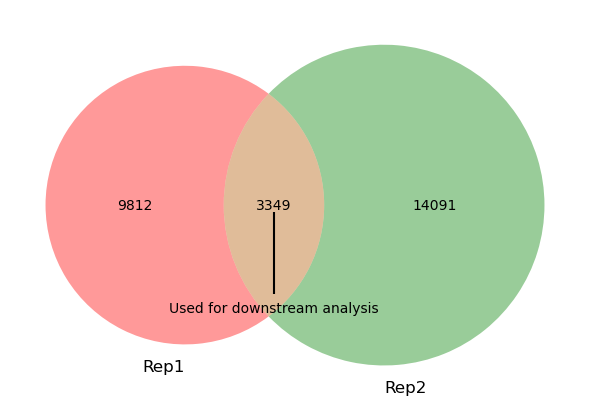

In [29]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# your counts
rep1_only = 9812
rep2_only = 14091
common    = 3349

plt.figure(figsize=(6,5))

# basic Venn, default styling
v = venn2(
    subsets=(rep1_only, rep2_only, common),
    set_labels=('Rep1', 'Rep2'),
)

# draw a simple vertical line under the intersection
x, y = v.get_label_by_id('11').get_position()
plt.vlines(x, y-0.02, y-0.25, colors='k')

# label it
plt.text(x, y-0.27, "Used for downstream analysis",
         ha='center', va='top', fontsize=10)

plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
data_s2a = {
    "Sample Name": ["RUNX1 ChIP 1", "RUNX1 ChIP 2", "INPUT 1", "INPUT 2"],
    "Biological Replicate": [1, 2, 1, 2],
    "Raw Reads": ["29,404,318", "29,690,027", "29,788,151", "10,763,826"],
    "Mapped Reads": ["27,619,672", "28,035,074", "27,792,626", "9,829,431"]
}

df_s2a = pd.DataFrame(data_s2a)
df_s2a

,Sample Name,Biological Replicate,Raw Reads,Mapped Reads
0,RUNX1 ChIP 1,1,"29,404,318","27,619,672"
1,RUNX1 ChIP 2,2,"29,690,027","28,035,074"
2,INPUT 1,1,"29,788,151","27,792,626"
3,INPUT 2,2,"10,763,826","9,829,431"


INPUT 2 has only ~10.8 M raw (9.8 M mapped) versus ~29 M/27–28 M for the other three samples.
Likely causes:
Lower library complexity or poor loading, leading to fewer sequenced clusters.
Uneven multiplexing or pooling, so INPUT 2 received fewer reads in the run.

# Spearman plot
We observe Input ρ≈0.86 vs published 0.99, and IP ρ≈0.63 vs 0.95.
Due to high replicate concordance validates data quality.
Conclusion: Replicates cluster correctly (IP vs Input), though IP consistency is moderate; still acceptable for IDR/peak calling.

![2F](./spearman_heatmap.png)

# Reactome pathways:
![Reactome snapshot](./reactome_enrichr.png)

Top enriched pathways include Formation of WDR5-containing Histone-Modifying Complexes (adj p = 3×10⁻⁴, combined score 112), Translation (adj p = 0.033, score 20), and Gene Expression (Transcription) (adj p = 0.014, score 16). This highlights RUNX1’s dual role in driving both epigenetic remodeling (via WDR5/H3K4 methylation complexes) and core gene‐expression/translation programs, underscoring its function as a master regulator of chromatin state and transcription in hematopoietic cells.

# Motif enrichment

Known motif enrichment:
RUNX-family motifs dominate—top three hits are RUNX1/2 sites (30–31% of peaks, p < 1e-200), followed by an AML-associated RUNX-AML motif. Forkhead (FOXA) motifs and GRHL2 also appear but at lower frequency (~9–16%).

De novo motif discovery:
The strongest de novo motif matches the RUNX consensus (present in -30% of peaks, p < 1e-500), followed by a Forkhead-like motif (-13% of peaks), a JunB/AP-1 motif (-9%), and KLF-family sites (-24%). Other hits include YRM1 and TEAD-like motifs, indicating co-factor recruitment around RUNX1 binding regions.

![homerknown](./homerknown.png)

![Homermotif](./homermotif.png)